In [6]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mmocc.plot_utils import fig_column_width, golden_ratio
from mmocc.config import cache_path

base = cache_path / "habitat_explainability"
per_desc_path = base / "habitat_canopy_error_per_descriptor.csv"
per_loc_path = base / "habitat_canopy_error_per_location.csv"
summary_path = base / "habitat_canopy_error_summary.csv"

per_desc = pd.read_csv(per_desc_path)
per_loc = pd.read_csv(per_loc_path)
summary = pd.read_csv(summary_path)

per_desc.head(), per_loc.head(), summary.head()

(                               taxon_id        scientific_name common_name  \
 0  00804e75-09ef-44e5-8984-85e365377d47  Antilocapra americana   pronghorn   
 1  00804e75-09ef-44e5-8984-85e365377d47  Antilocapra americana   pronghorn   
 2  00804e75-09ef-44e5-8984-85e365377d47  Antilocapra americana   pronghorn   
 3  00804e75-09ef-44e5-8984-85e365377d47  Antilocapra americana   pronghorn   
 4  00804e75-09ef-44e5-8984-85e365377d47  Antilocapra americana   pronghorn   
 
   descriptor_backbone  descriptor_index  \
 0         expert_clip                 0   
 1         expert_clip                 1   
 2         expert_clip                 2   
 3         expert_clip                 3   
 4         expert_clip                 4   
 
                                      descriptor_text  descriptor_score  \
 0  Herbaceous (Subcanopy herbaceous vegetation gr...               3.0   
 1           Forbs (Herbaceous dicotyledonous plants)               2.0   
 2  Shrub (Subcanopy shrubs great

In [7]:
# Cleaned correlation series
corrs = per_desc["pearson_abs_error_canopy"].dropna()
backbones = per_desc["descriptor_backbone"].unique().tolist()

print("Per-descriptor rows:", len(per_desc))
print("Non-NaN correlations:", len(corrs))
print(summary.groupby("descriptor_backbone").size())

Per-descriptor rows: 65
Non-NaN correlations: 65
descriptor_backbone
expert_clip     13
visdiff_clip    27
dtype: int64


/tmp/ipykernel_350614/936315597.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


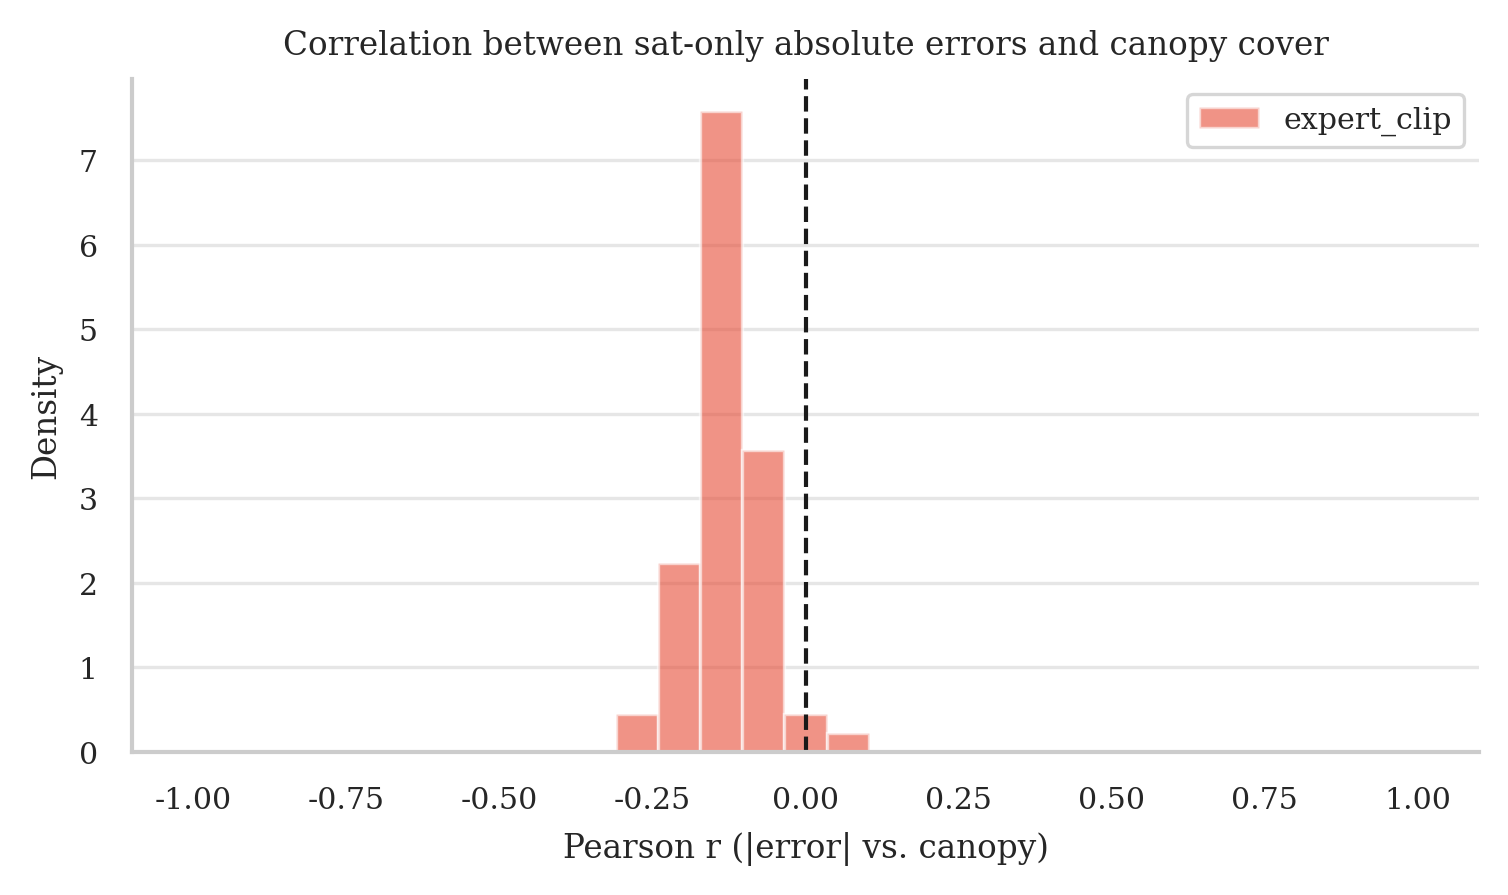

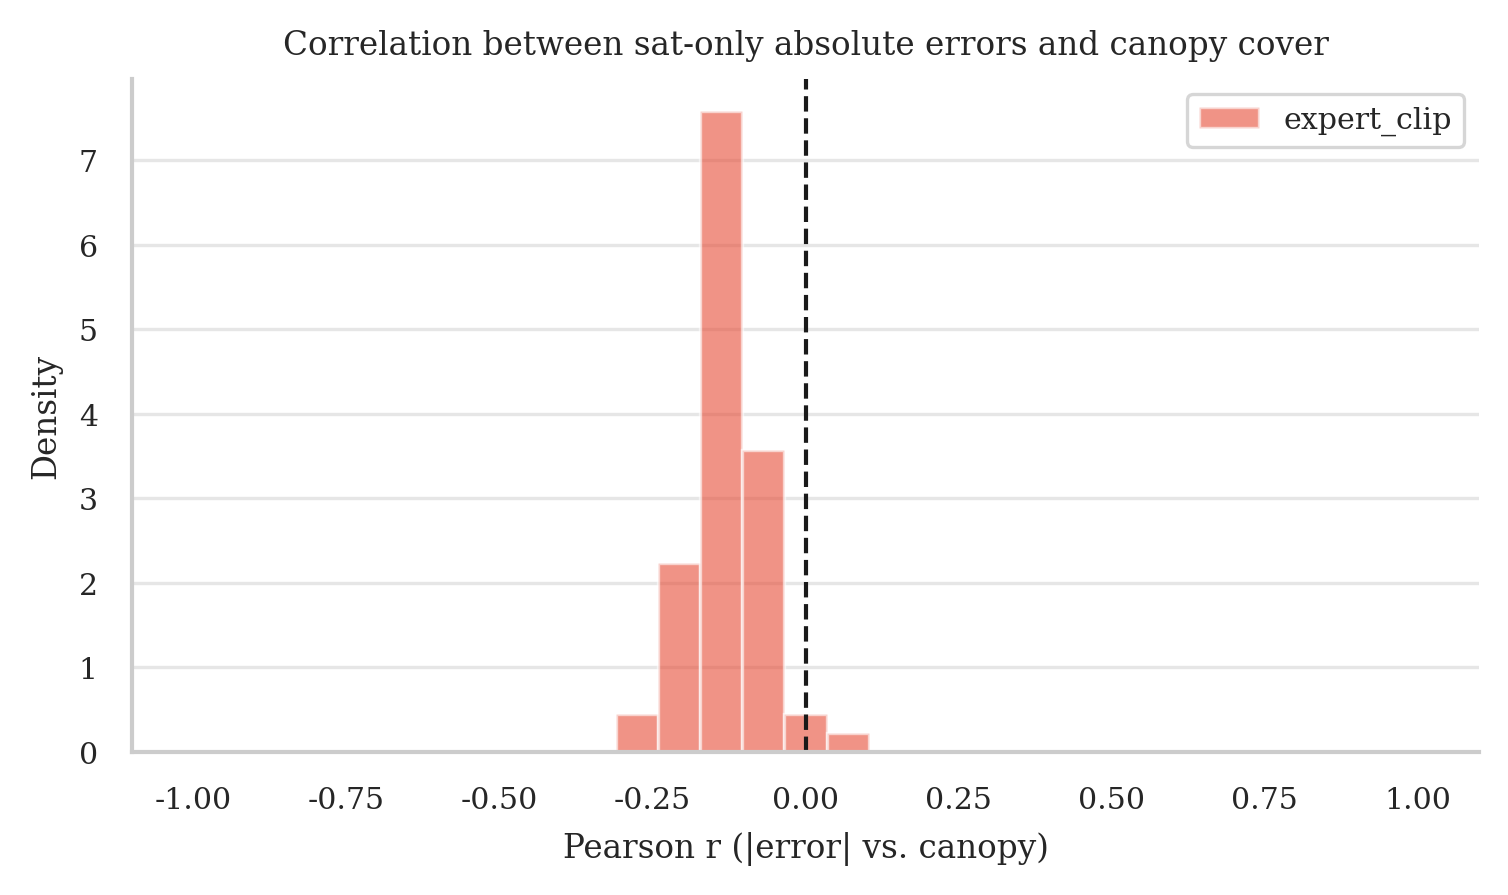

In [8]:
# Histogram of Pearson correlations by descriptor backbone
fig, ax = plt.subplots(figsize=(fig_column_width * 1.25, fig_column_width * 0.75))
bins = np.linspace(-1, 1, 30)
for backbone in backbones:
    subset = per_desc.loc[
        per_desc["descriptor_backbone"] == backbone, "pearson_abs_error_canopy"
    ].dropna()
    ax.hist(subset, bins=bins, alpha=0.6, label=backbone, density=True)
ax.axvline(0, color="k", linestyle="--", linewidth=1)
ax.set_xlabel("Pearson r (|error| vs. canopy)")
ax.set_ylabel("Density")
ax.legend()
ax.set_title("Correlation between sat-only absolute errors and canopy cover")
plt.tight_layout()
fig

Location-level Pearson r (mean |error| vs canopy): -0.16972070212429918


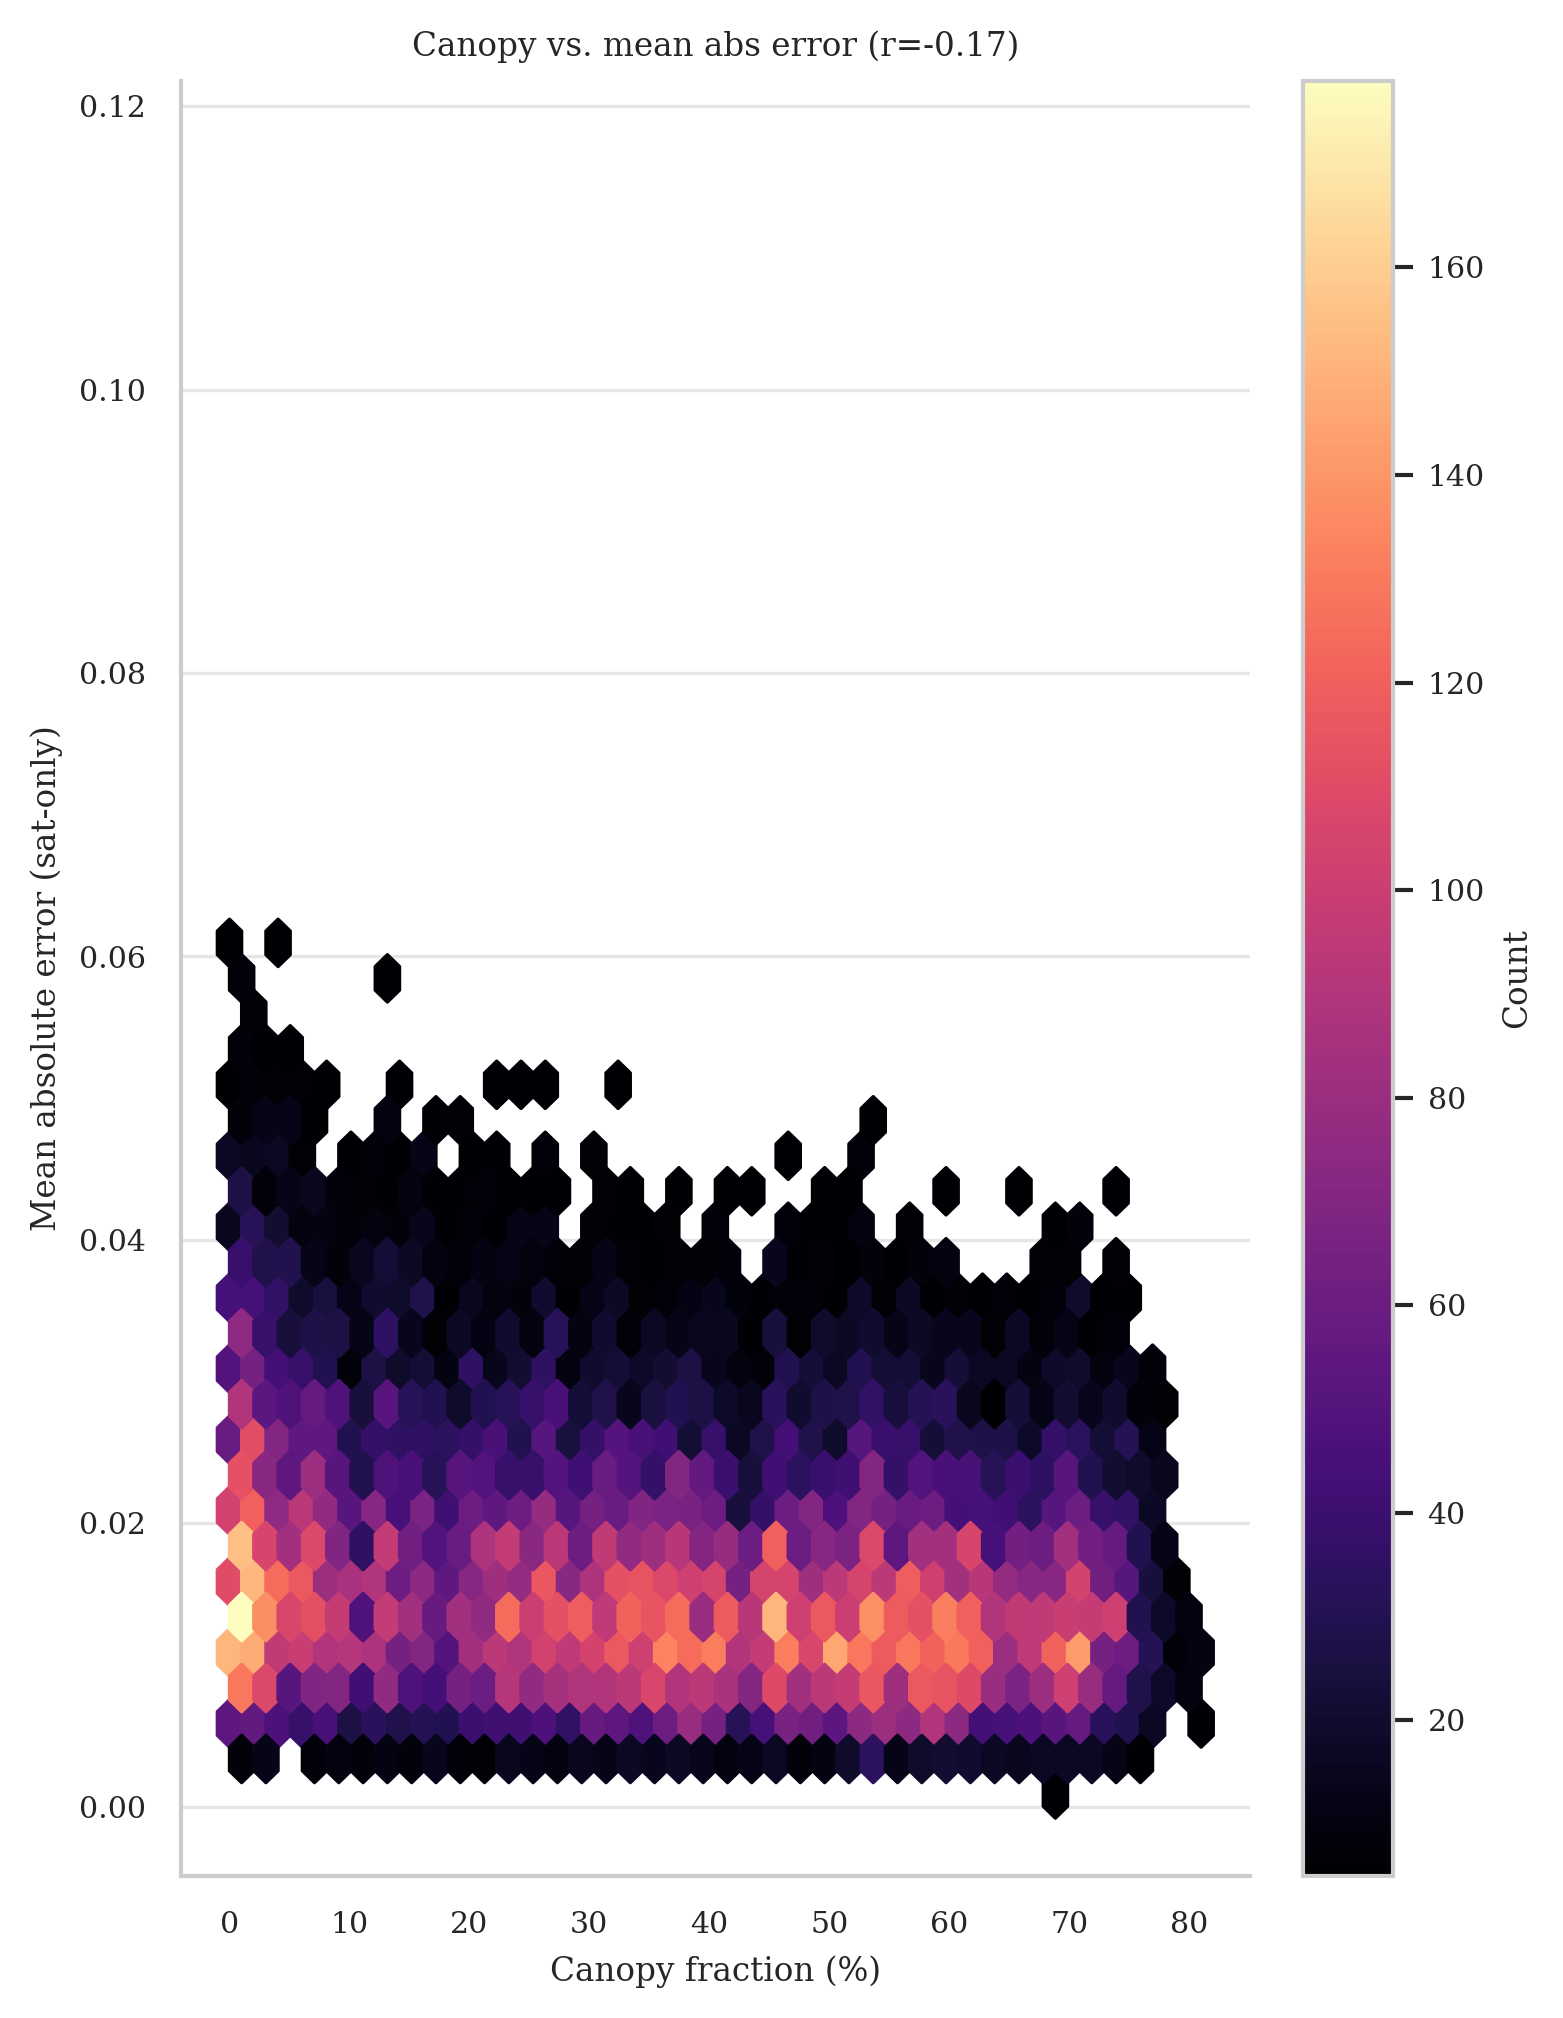

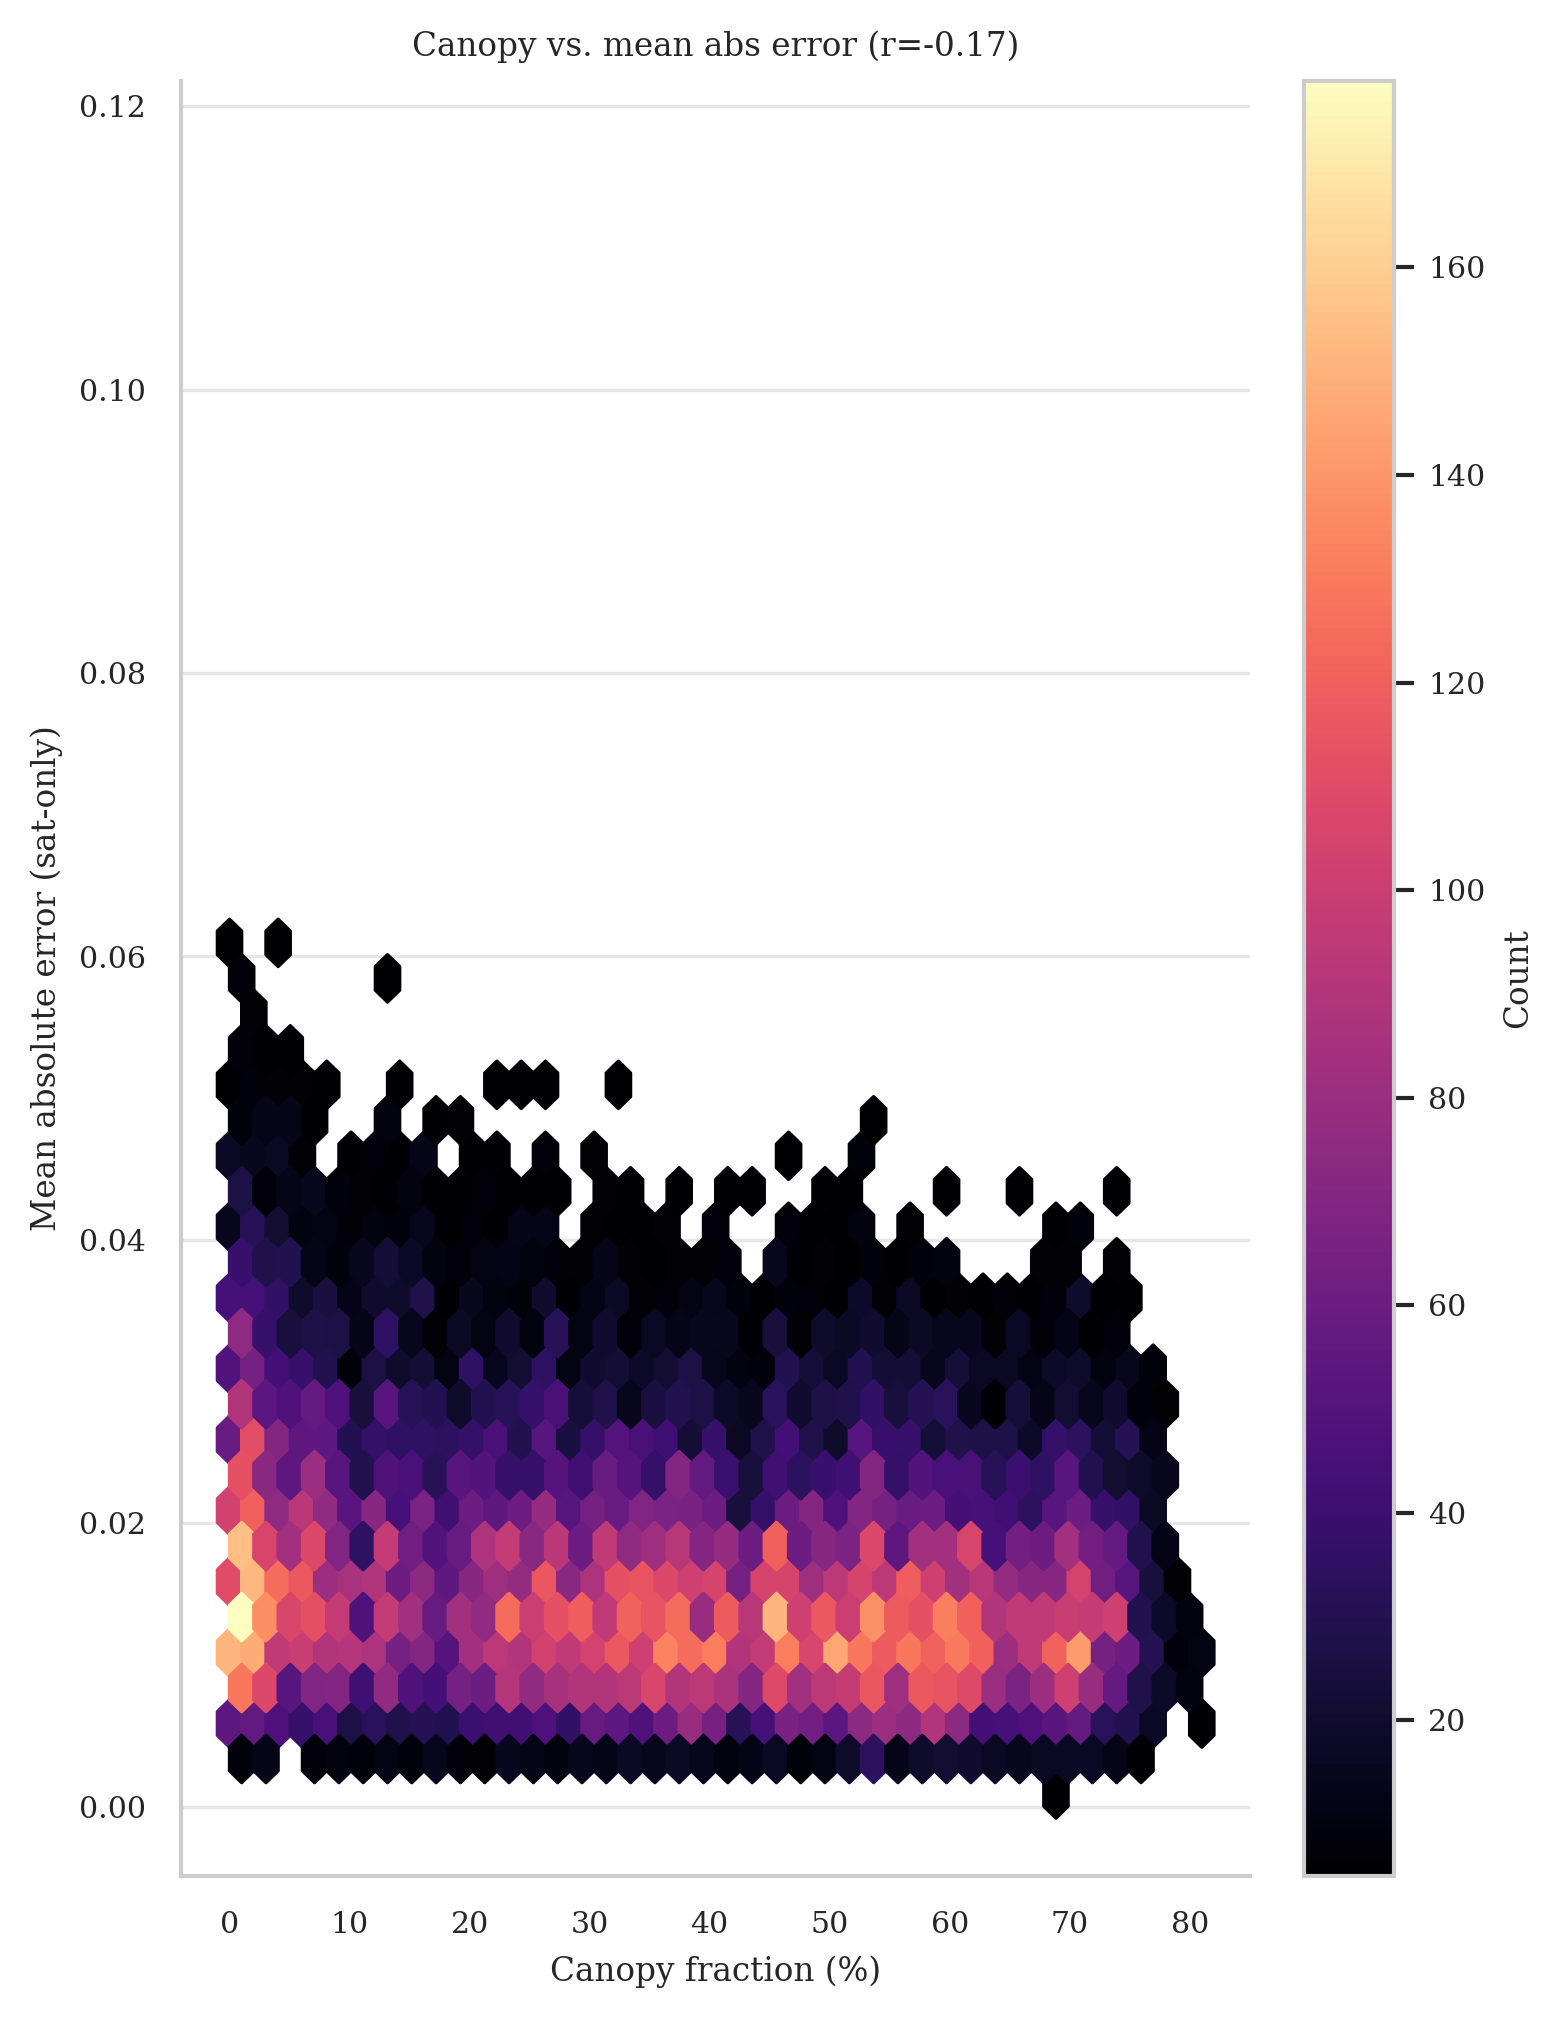

In [9]:
# Per-location mean absolute error vs canopy
error_cols = [c for c in per_loc.columns if c.startswith("abs_error_")]
per_loc = per_loc.copy()
per_loc["mean_abs_error"] = per_loc[error_cols].mean(axis=1)
valid = per_loc[["mean_abs_error", "canopy_fraction"]].dropna()
corr_loc = valid.corr().iloc[0, 1]
print("Location-level Pearson r (mean |error| vs canopy):", corr_loc)

fig, ax = plt.subplots(
    figsize=(fig_column_width * 1.25, fig_column_width * golden_ratio)
)
hb = ax.hexbin(
    valid["canopy_fraction"],
    valid["mean_abs_error"],
    gridsize=40,
    cmap="magma",
    mincnt=5,
)
ax.set_xlabel("Canopy fraction (%)")
ax.set_ylabel("Mean absolute error (sat-only)")
ax.set_title(f"Canopy vs. mean abs error (r={corr_loc:.2f})")
fig.colorbar(hb, ax=ax, label="Count")
fig

In [10]:
# Backbone-level summary table
table = (
    per_desc.groupby("descriptor_backbone")["pearson_abs_error_canopy"]
    .agg(["count", "mean", "std", "min", "max"])
    .rename(columns={"count": "n"})
)
table

,n,mean,std,min,max
descriptor_backbone,,,,,
expert_clip,65,-0.131679,0.057334,-0.296883,0.037448
